In [1]:
import datetime
import glob
import logging
import os
import tarfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray

import G211

import seaborn as sns; sns.set_theme()
logging.basicConfig(format="%(asctime)s %(message)s", level=logging.INFO)

In [2]:
# Get lightning data from older tar file. Old tar files can be accessed /gpfs/csfs1/ral/aap/hardt/LTG directly, but 
# recent tar files must be transfered with GLOBUS from https://app.globus.org/file-manager/collections "ENTLN lightning ascii files"
def getltg(valid_time, path="temp", idir="/gpfs/csfs1/ral/aap/hardt/LTG"):
    ifile = os.path.join(idir, valid_time.strftime("%Y"), valid_time.strftime("%m%d"), valid_time.strftime("%Y%m%d_ENTLN_ascii_data.tar"))
    tar = tarfile.open(ifile, mode='r')
    members = [os.path.join(path, x) for x in tar.getnames()]
    logging.info(f"extractall {len(members)} members from {ifile} ")
    ret = tar.extractall(path=path)
    return members

In [3]:
# Won't work on cheyenne. Doesn't see campaign storage.
members = getltg(pd.to_datetime("20180321"))

2023-09-26 15:21:53,740 extractall 1273 members from /gpfs/csfs1/ral/aap/hardt/LTG/2018/0321/20180321_ENTLN_ascii_data.tar 


In [4]:
idir="/glade/campaign/mmm/parc/ahijevyc/wbug_lightning"
idir="./wbug_lightning"

#### <code>gunzip -c *_ltg.asc.gz | grep f</code> into big text file and use <code>txt2par.py</code> to convert to parquet 

In [5]:
ifiles = glob.glob(os.path.join(idir,"flash20*.par"))
logging.info(f"found {len(ifiles)} flash parquet files")

ifiles = ifiles[0] # UNCOMMENT FOR DEBUGGING

df = pd.concat([pd.read_parquet(x, engine="pyarrow") for x in ifiles])

2023-09-22 15:59:54,944 found 52 flash parquet files


PermissionError: [Errno 13] Cannot list directory './work_sobash/miniconda3/pkgs/setuptools-50.3.1-py38h06a4308_1b64ye8st'. Detail: [errno 13] Permission denied

In [ ]:
time0 = pd.to_datetime("20180101")
past = df["time"] < time0
logging.warning(f"{past.sum()} ({past.sum()/len(df):%}) flashes before {time0}")
future = df["time"] >= datetime.datetime.utcnow()
logging.warning(f"{future.sum()} ({future.sum()/len(df):%}) flashes in future")
outofbounds = (df["lat"] < 11) | (df["lat"] > 62) | (df["lon"] < -150) | (df["lon"] > -50)
logging.warning(f"{outofbounds.sum()} ({outofbounds.sum()/len(df):%}) flashes out-of-bounds")

df0 = df[~past & ~future & ~outofbounds]
df0

In [ ]:
dfd = df0.set_index("time").sort_index()
dfd

In [ ]:
dfd.resample("30s").count()
#.rolling(window=2, center=False, closed="left").sum()

In [ ]:
dfd.resample("30s").count().rolling(window=2,step=2).sum()

In [ ]:
dfd.asfreq

In [ ]:
df0.plot.hexbin(x="lon", y="lat", figsize=(10,7))

### flash.G211.nc was created separately by ~/bin/wbug_G211.py

In [ ]:
ifile = os.path.join(idir,f"flash.G211.nc")
ds = xarray.open_dataset(ifile)

In [ ]:
sns.histplot(ds.time.dt.hour,bins=range(25))

In [ ]:
ds = ds.sel(time=slice('2020-06-20 00:00:00','2020-06-20 00:00:00'))
ds

In [ ]:
ds.ic_hourly.sel(y=25,x=46).data

In [ ]:
dd = ds.sum(dim=["y","x"]).groupby(ds.time.dt.hour)

In [ ]:
ds.ic_hourly.sum(), ds.ic_hourly.max()

In [ ]:
fig, ax = plt.subplots(figsize=(16,1))
sns.histplot(ds.time,bins=260,ax=ax)

In [ ]:
ds

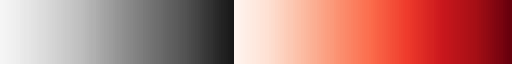

In [59]:
import cartopy.crs as ccrs

from matplotlib.colors import ListedColormap, BoundaryNorm
from statisticplot import make_map
import nclcmaps

cmap = plt.get_cmap('rainbow')

test = nclcmaps.colors['MPL_Greys'][10:-10:] + nclcmaps.colors['MPL_Reds']
cmap = ListedColormap(test, "GreysReds")
norm = BoundaryNorm(np.arange(0,28,2), ncolors=cmap.N, clip=True)
cmap

## lightning longterm average

In [7]:
ifile = os.path.join("wbug_lightning", "flash_40km.nc")
logging.info(f"open wbug {ifile}")
wb = xarray.open_dataset(ifile)
times = wb.time_coverage_start.values
logging.info(f"average {times.size} times")
wb = wb.mean(dim="time_coverage_start")
logging.info("done")

2023-06-06 15:53:02,200 open wbug wbug_lightning/flash_40km.nc
2023-06-06 15:53:03,037 average 83495 times
2023-06-06 15:53:30,071 done


In [62]:
assert times[1]-times[0] == pd.Timedelta(minutes=30)
# multiply by two because time blocks were 30-minutes and we want flashes per hour
wb["total flashes"] = xarray.DataArray(2*(wb.cg + wb.ic), attrs=dict(long_name="cg & ic flashes per hour"))

Text(0.5, 1.0, '2018-01-01T00:00:00.000000000 - 2022-12-31T23:30:00.000000000')

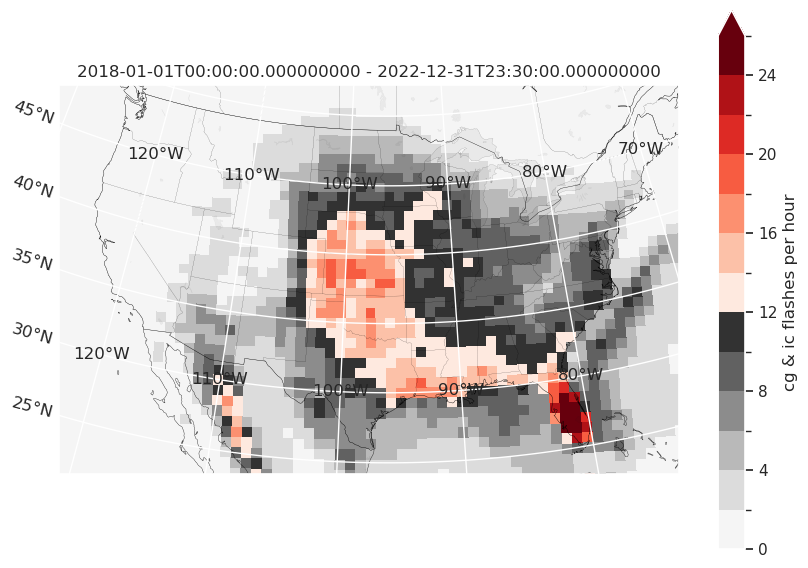

In [60]:
fig, ax = make_map()

sc = wb["total flashes"].plot(x="lon", y="lat",  cmap=cmap, transform=ccrs.PlateCarree(), norm=norm)
ax.set_title(f"{times.min()} - {times.max()}")

In [45]:
ds.

<xarray.Dataset>
Dimensions:              (time_coverage_start: 1, y: 65, x: 93)
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2020-07-26T09:2...
    lon                  (y, x) float64 ...
    lat                  (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    flashes              (time_coverage_start, y, x) float32 ...
Attributes:
    history:  Fri Feb 24 10:48:29 2023: ncra --prm_int 2018/20180213_1630.glm...
    NCO:      netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net, C...

2023-06-06 16:24:36,596 20180213T1830
2023-06-06 16:24:36,603 20180213T1730


Text(0.5, 1.0, '20180213T1730 - 20221231T2330')

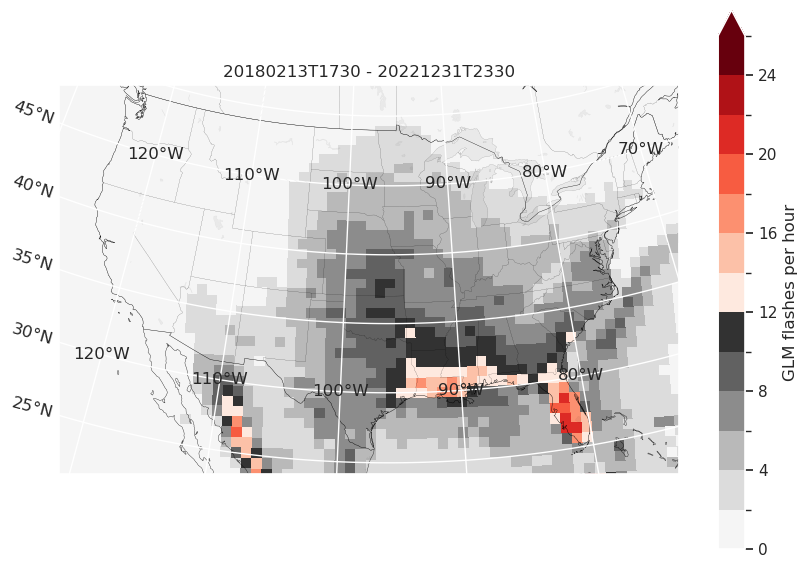

In [61]:
ifile = "GLM/longterm_average.glm.nc"
ds = xarray.open_dataset(ifile)
fig, ax = make_map()
ifiles = ds.attrs["history"].replace("_","T").split()[8:-1]
logging.info(ifiles[1][5:-7])
logging.info(ifiles[0][5:-7])
assert pd.to_datetime(ifiles[1][5:-7]) - pd.to_datetime(ifiles[0][5:-7]) == pd.Timedelta(hours=1)
time_range = " - ".join([ifiles[0][5:-7],ifiles[-1][5:-7]])
ds["flashes"] = xarray.DataArray(ds["flashes"], attrs = dict(long_name="GLM flashes per hour"))
sc = ds["flashes"].plot(x="lon", y="lat", cmap=cmap, transform=ccrs.PlateCarree(), ax=ax, norm=norm)
ax.set_title(time_range)

In [10]:
ifiles = ds.attrs["history"].split()[8:-1]
print(ifiles[0],ifiles[-1])

2018/20180213_1730.glm.nc 2022/20221231_2330.glm.nc
